In [1]:
import torch 
import torch.nn as nn  
import torch.nn.functional as F
import pandas as pd  
from data_process import *
import torch.optim as optim 
from tqdm import tqdm 

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(ResidualBlock, self).__init__()
        self.dilated_conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=dilation, dilation=dilation)
        self.batch_norm1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dilated_conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=dilation, dilation=dilation)
        self.batch_norm2 = nn.BatchNorm1d(out_channels)
        
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.dilated_conv1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dilated_conv2(out)
        out = self.batch_norm2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
            
        return self.relu(out + residual)

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.dense1 = nn.Linear(in_channels, out_channels)
        self.batch_norm1 = nn.BatchNorm1d(out_channels)
        self.dense2 = nn.Linear(out_channels, out_channels)
        self.batch_norm2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.dense1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dense2(out)
        out = self.batch_norm2(out)
        return out

class DeepTCN(nn.Module):
    def __init__(self, num_series, num_outputs, num_blocks, kernel_size, hidden_channels, num_covariates):
        super(DeepTCN, self).__init__()
        self.num_covariates = num_covariates
        layers = []
        for i in range(num_blocks):
            dilation_size = 2 ** i
            in_channels = num_series if i == 0 else hidden_channels
            layers += [ResidualBlock(in_channels, hidden_channels, kernel_size, dilation_size)]
        
        self.encoder = nn.Sequential(*layers)
        self.decoder = Decoder(hidden_channels + num_covariates, hidden_channels)
        self.output_layer = nn.Linear(hidden_channels, num_outputs)
        
    def forward(self, x, covariates):
        # Encoder
        x = x.permute(0, 2, 1)  # Assuming input of shape [batch, seq_len, features]
        x = self.encoder(x)
        
        # Decoder
        x = x.mean(dim=2)  # Global average pooling
        
        covariates = covariates.mean(dim=1) # Reduce the temporal dimension of covariates as well
        combined = torch.cat((x, covariates), dim=1) # Concatenate along the feature dimension
        
        x = self.decoder(combined)
        
        # Output layer
        x = self.output_layer(x)
        return x

In [5]:
num_series = 32  # Historical features
num_covariates = 6  # Future covariates
num_outputs = 2  # Output sequence length
num_blocks = 4  # Number of residual blocks
kernel_size = 3  # Kernel size
hidden_channels = 64  # Number of filters in convolutional layers

model = DeepTCN(num_series=num_series, num_outputs=num_outputs, num_blocks=num_blocks, 
                kernel_size=kernel_size, hidden_channels=hidden_channels, num_covariates=num_covariates)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

In [6]:
# Load the data
flights = pd.read_csv("flights.csv")
features = getFeatures() 
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(flights, covariates=True)


DeepTCN(
  (encoder): Sequential(
    (0): ResidualBlock(
      (dilated_conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dilated_conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualBlock(
      (dilated_conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dilated_conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResidualBlock(
      (d

In [6]:
num_series = 32  # Historical features
num_covariates = 6  # Future covariates
num_outputs = 2  # Output sequence length
num_blocks = 4  # Number of residual blocks
kernel_size = 3  # Kernel size
hidden_channels = 64  # Number of filters in convolutional layers

model = DeepTCN(num_series=num_series, num_outputs=num_outputs, num_blocks=num_blocks, 
                kernel_size=kernel_size, hidden_channels=hidden_channels, num_covariates=num_covariates)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
best_val_loss = float('inf')
train_losses, val_losses = [], []
best_epoch = 0 



# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    train_loader_with_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")
    
    for batch_idx, (features, targets) in enumerate(train_loader_with_progress):
        # Separate historical features and covariates and move to device
        historical_features = features[:, :, :-6].to(device)
        covariates = features[:, :, -6:].to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(historical_features, covariates)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step() 
        
        total_loss += loss.item() 
        train_loader_with_progress.set_postfix({'Train Loss': loss.item()})
        
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')
    train_losses.append(total_loss/len(train_loader))
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_loader_with_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")
    with torch.no_grad():  # Disable gradient calculation
        for val_features, val_targets in val_loader_with_progress:
            val_historical_features = val_features[:, :, :-6].to(device)
            val_covariates = val_features[:, :, -6:].to(device)
            val_targets = val_targets.to(device)

            val_outputs = model(val_historical_features, val_covariates)
            val_loss += criterion(val_outputs, val_targets).item()
            val_loader_with_progress.set_postfix({'Val Loss': criterion(val_outputs, val_targets).item()})
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss}')
    
    # Save the model with least validation loss
    if val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'DeepTCN_model_epoch_{best_epoch}_val_loss_{best_val_loss:.4f}.pt')

# After training
print(f'Best Validation Loss: {best_val_loss} at Epoch: {best_epoch}')



' \n\n# Training loop\nnum_epochs = 20\nfor epoch in range(num_epochs):\n    model.train()  # Set the model to training mode\n    total_loss = 0\n    train_loader_with_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")\n    \n    for batch_idx, (features, targets) in enumerate(train_loader_with_progress):\n        # Separate historical features and covariates and move to device\n        historical_features = features[:, :, :-6].to(device)\n        covariates = features[:, :, -6:].to(device)\n        targets = targets.to(device)\n        \n        # Forward pass\n        outputs = model(historical_features, covariates)\n        loss = criterion(outputs, targets)\n        \n        # Backward pass and optimization\n        optimizer.zero_grad()\n        loss.backward() \n        optimizer.step() \n        \n        total_loss += loss.item() \n        train_loader_with_progress.set_postfix({\'Train Loss\': loss.item()})\n        \n    print(f\'Epoch {epoch+1}/{nu

In [10]:
def plot_output(y_pred_seq, y_true_seq, seq_len, focus_length=100):
    pred_arr = y_pred_seq[:focus_length].cpu().numpy().flatten()
    true_arr = y_true_seq[:focus_length].cpu().numpy().flatten()

    # Set up subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Plot predictions and actual values
    axs[0].plot(pred_arr, 'r-', label='Predicted', linewidth=2.0)
    axs[0].plot(true_arr, 'b-', label='Actual', linewidth=2.0)
    axs[0].set_title('Predicted vs Actual Power Consumption')
    axs[0].set_ylabel('Power Consumption')
    axs[0].legend()
    axs[0].grid(True)

    # Plot the difference
    difference = np.abs(pred_arr - true_arr)
    axs[1].plot(difference, 'k--', label='Difference', linewidth=2.0)
    axs[1].set_title('Difference in Power Consumption')
    axs[1].set_ylabel('Absolute Difference')
    axs[1].set_xlabel('Sequence Index')
    axs[1].legend()
    axs[1].grid(True)

    # Show the plot
    plt.show()

In [10]:


from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
model.load_state_dict(torch.load('DeepTCN_model_epoch_15_val_loss_0.0015.pt', map_location=torch.device('cpu')))
model.eval()

test_nums = d_split['test']
# test_nums.remove(273)

for f_num in d_split['test']:
    test_data = data[data['flight'] == f_num]
    input_seq, output_seq = create_sequences(test_data[features].values, 
                                            test_data['power'].values, 10, 2)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

    print(input_seq.shape)
    print(output_seq.shape)

    print(f"Flight {f_num}:")

    with torch.no_grad():
        
        historical_features = input_seq[:, :, :-6]  # All but the last 6 columns
        covariates = input_seq[:, :, -6:]          # Only the last 6 columns
        
        outputs = model(historical_features, covariates)
        outputs = outputs.squeeze(-1)  # Adjust dimensions if necessary
        targets = output_seq
    
        error = nn.MSELoss()(outputs, targets)
        print(f"Test loss: {error}")

        mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
        print(f"MAPE: {mape}")

torch.Size([1187, 10, 32])
torch.Size([1187, 2])
Flight 3:


RuntimeError: Given groups=1, weight of size [64, 32, 3], expected input[1187, 26, 10] to have 32 channels, but got 26 channels instead

32
38
Test loss: 0.0014223776524886489
MAPE: inf


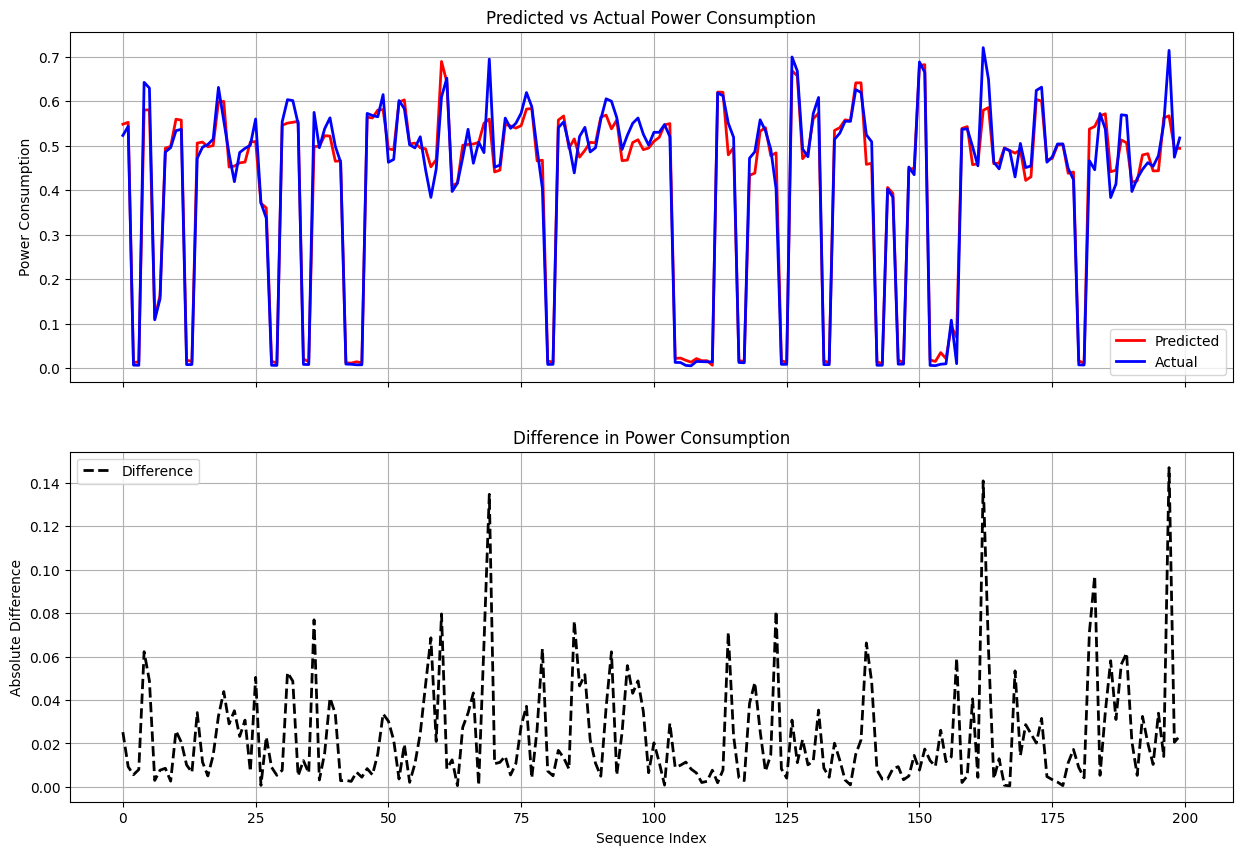

In [12]:
import random
import matplotlib.pyplot as plt 
import numpy as np    

model.load_state_dict(torch.load('DeepTCN_model_epoch_15_val_loss_0.0015.pt', map_location=torch.device('cpu')))
model.eval()

features = getFeatures()
print(len(features))
features += ['x_future','y_future','z_future'] + ['x_change', 'y_change','z_change']
print(len(features))

input_seq, output_seq = create_sequences_new(data=data, features=features, target='power', input_seq_len=10, output_seq_len=2)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

# Make predictions
with torch.no_grad():
    historical_features = input_seq[:, :, :-6]  # All but the last 6 columns
    covariates = input_seq[:, :, -6:]          # Only the last 6 columns
    
    outputs = model(historical_features, covariates)
    outputs = outputs.squeeze(-1)  # Adjust dimensions if necessary
    targets = output_seq

    # Calculate error metrics
    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")

    # Call the function with the outputs and targets
    plot_output(outputs, targets, seq_len=2, focus_length=100)  # Focus on the first 100 sequences  